# 일상 대화 요약 EDA (Exploratory Data Analysis)

**목적**: 데이터 분석을 통한 성능 고도화 전략 수립

**분석 항목**:
1. **데이터 구조 확인** - 컬럼, 타입, 결측치
2. **텍스트 길이 분석** - 문자 단위, 압축 비율
3. **주제 분포** - 9,235개 고유 주제
4. **화자 분석** - 대부분 2명 대화
5. **발화 분석** - 대화 턴 수
6. **토큰 길이 분석** - KoBART tokenizer 기준
7. **특수 패턴 분석** - 시간, 금액, 전화번호 등
8. **PII 마스킹 분석** - 개인정보 마스킹 패턴
9. **문장 수 분석** - 문장 단위 압축 비율
10. **어휘 다양성 분석** - Type-Token Ratio
11. **N-gram 분석** - 자주 사용되는 표현
12. **성능 문제 샘플** - 긴 대화, 복잡한 구조
13. **Baseline 예측 비교** - ROUGE 점수 분석 (조건부)

---

## 1. 환경 설정 및 데이터 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json
import re
from tqdm import tqdm

# tqdm pandas 통합
tqdm.pandas()

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ 라이브러리 로딩 완료")

✅ 라이브러리 로딩 완료


In [2]:
# 데이터 로딩
train_df = pd.read_csv('../data/train.csv')
dev_df = pd.read_csv('../data/dev.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Train: {len(train_df):,} samples")
print(f"Dev:   {len(dev_df):,} samples")
print(f"Test:  {len(test_df):,} samples")
print(f"\n✅ 데이터 로딩 완료")

Train: 12,457 samples
Dev:   499 samples
Test:  499 samples

✅ 데이터 로딩 완료


## 2. 데이터 구조 확인

In [3]:
# Train 데이터 구조
print("=" * 80)
print("Train 데이터 구조")
print("=" * 80)
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nData Types:")
print(train_df.dtypes)
print(f"\n결측치:")
print(train_df.isnull().sum())

# 샘플 1개 확인
print("\n" + "=" * 80)
print("샘플 예시 (Train[0])")
print("=" * 80)
sample = train_df.iloc[0]
print(f"\nID: {sample['fname']}")
print(f"\nDialogue (처음 200자):\n{sample['dialogue'][:200]}...")
print(f"\nSummary:\n{sample['summary']}")

Train 데이터 구조

Columns: ['fname', 'dialogue', 'summary', 'topic']

Data Types:
fname       object
dialogue    object
summary     object
topic       object
dtype: object

결측치:
fname       0
dialogue    0
summary     0
topic       0
dtype: int64

샘플 예시 (Train[0])

ID: train_0

Dialogue (처음 200자):
#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? 
#Person2#: 건강검진을 받으려고 왔어요. 
#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. 
#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. 
#Person...

Summary:
Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필요성을 안내받고 흡연 습관 개선을 위한 도움을 제안받았습니다.


## 3. 텍스트 길이 분석

대화와 요약문의 길이 분포를 분석합니다.

In [4]:
# 텍스트 길이 계산 (문자 단위)
def add_length_stats(df, name):
    """텍스트 길이 통계 추가"""
    df = df.copy()
    df['dialogue_len'] = df['dialogue'].str.len()
    if 'summary' in df.columns:
        df['summary_len'] = df['summary'].str.len()
        df['compression_ratio'] = df['dialogue_len'] / df['summary_len']
    
    print(f"\n{'='*80}")
    print(f"{name} - 텍스트 길이 통계 (문자 단위)")
    print(f"{'='*80}")
    print(f"\n[Dialogue 길이]")
    print(df['dialogue_len'].describe())
    
    if 'summary' in df.columns:
        print(f"\n[Summary 길이]")
        print(df['summary_len'].describe())
        print(f"\n[압축 비율 (dialogue/summary)]")
        print(df['compression_ratio'].describe())
    
    return df

# 통계 계산
train_df = add_length_stats(train_df, "Train")
dev_df = add_length_stats(dev_df, "Dev")
test_df = add_length_stats(test_df, "Test")


Train - 텍스트 길이 통계 (문자 단위)

[Dialogue 길이]
count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: dialogue_len, dtype: float64

[Summary 길이]
count    12457.000000
mean        85.789436
std         33.811948
min         13.000000
25%         61.000000
50%         80.000000
75%        104.000000
max        376.000000
Name: summary_len, dtype: float64

[압축 비율 (dialogue/summary)]
count    12457.000000
mean         4.848251
std          1.704514
min          1.010000
25%          3.703125
50%          4.607843
75%          5.707692
max         19.846154
Name: compression_ratio, dtype: float64

Dev - 텍스트 길이 통계 (문자 단위)

[Dialogue 길이]
count     499.000000
mean      400.054108
std       186.163807
min       114.000000
25%       273.000000
50%       367.000000
75%       487.000000
max      1269.000000
Name: dialogue_len, dtype: float64

[Summary 길이]
count    499.000000
me

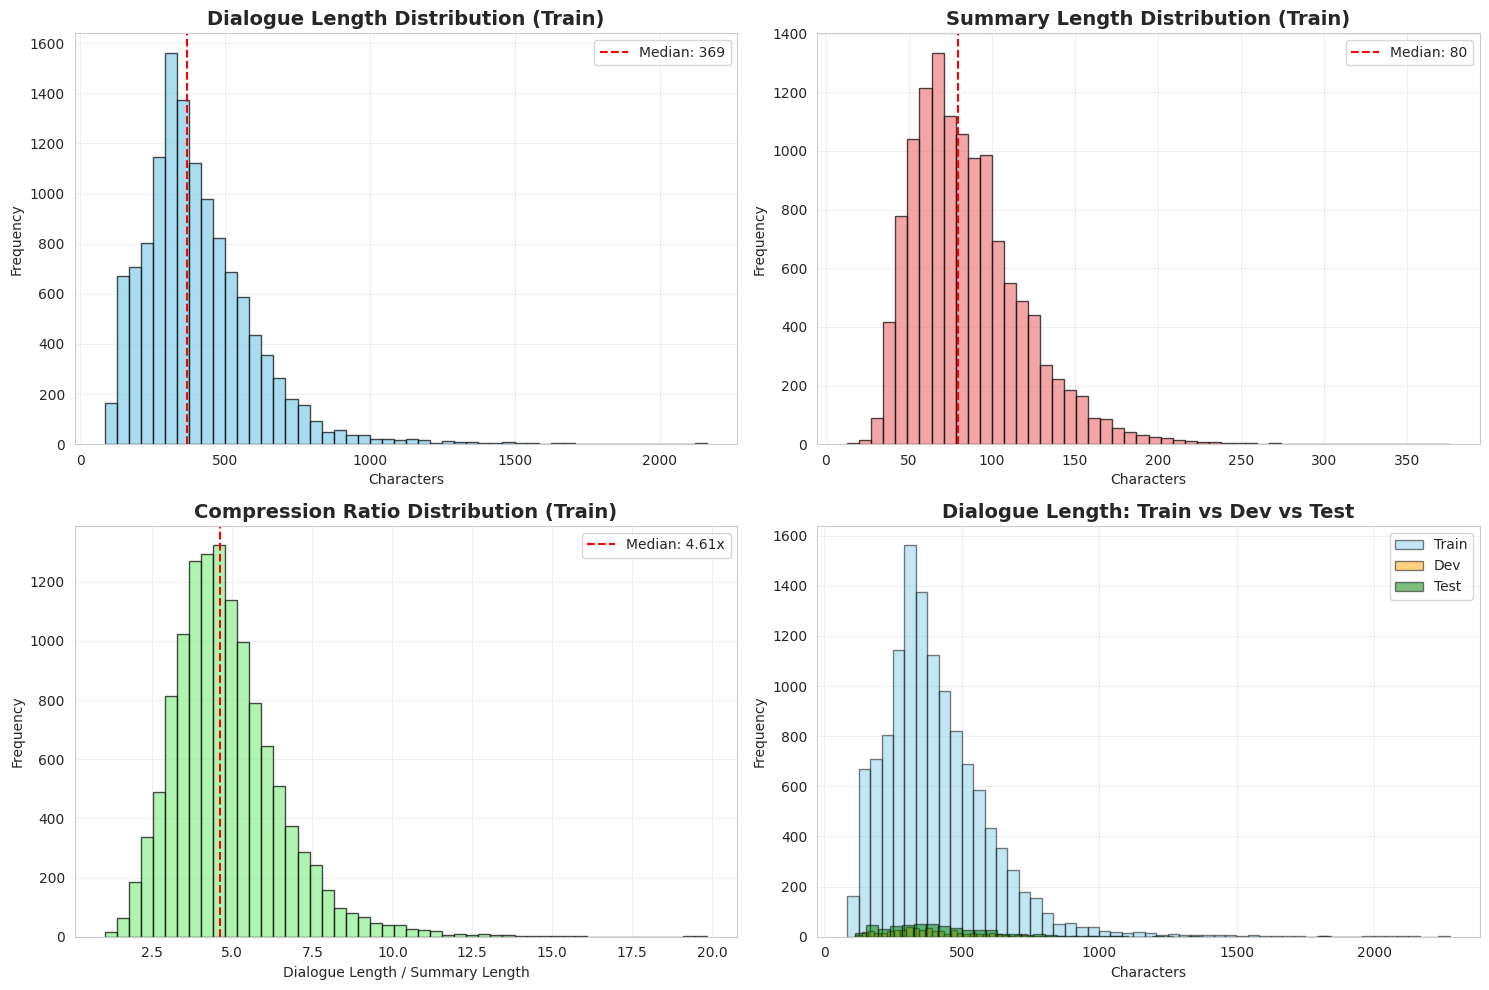


✅ 텍스트 길이 분포 시각화 완료


In [5]:
# 시각화: 텍스트 길이 분포
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dialogue 길이 (Train)
axes[0, 0].hist(train_df['dialogue_len'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(train_df['dialogue_len'].median(), color='red', linestyle='--', label=f'Median: {train_df["dialogue_len"].median():.0f}')
axes[0, 0].set_title('Dialogue Length Distribution (Train)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Summary 길이 (Train)
axes[0, 1].hist(train_df['summary_len'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(train_df['summary_len'].median(), color='red', linestyle='--', label=f'Median: {train_df["summary_len"].median():.0f}')
axes[0, 1].set_title('Summary Length Distribution (Train)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Compression Ratio (Train)
axes[1, 0].hist(train_df['compression_ratio'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(train_df['compression_ratio'].median(), color='red', linestyle='--', label=f'Median: {train_df["compression_ratio"].median():.2f}x')
axes[1, 0].set_title('Compression Ratio Distribution (Train)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Dialogue Length / Summary Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Train vs Dev vs Test Dialogue 길이 비교
axes[1, 1].hist(train_df['dialogue_len'], bins=50, alpha=0.5, label='Train', color='skyblue', edgecolor='black')
axes[1, 1].hist(dev_df['dialogue_len'], bins=50, alpha=0.5, label='Dev', color='orange', edgecolor='black')
axes[1, 1].hist(test_df['dialogue_len'], bins=50, alpha=0.5, label='Test', color='green', edgecolor='black')
axes[1, 1].set_title('Dialogue Length: Train vs Dev vs Test', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Characters')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 텍스트 길이 분포 시각화 완료")

## 4. 주제(Topic) 분석

`topic` 컬럼의 분포를 분석합니다.

In [6]:
# topic 분석 (단일 문자열 형태)
print("\n" + "="*80)
print("주제(Topic) 분포 분석")
print("="*80)

# Train topic 분포
topic_counts = train_df['topic'].value_counts()
print(f"\n총 고유 주제 수 (Train): {len(topic_counts)}")
print(f"\n상위 20개 주제:")
print("="*80)
for topic, count in topic_counts.head(20).items():
    print(f"{topic:30s}: {count:4d} ({count/len(train_df)*100:5.2f}%)")

# Dev topic 분포
print("\n" + "="*80)
print(f"총 고유 주제 수 (Dev): {len(dev_df['topic'].value_counts())}")

# Test에는 topic 없음 (추론 대상)
if 'topic' in test_df.columns:
    print(f"총 고유 주제 수 (Test): {len(test_df['topic'].value_counts())}")


주제(Topic) 분포 분석

총 고유 주제 수 (Train): 9235

상위 20개 주제:
음식 주문                         :  130 ( 1.04%)
취업 면접                         :  109 ( 0.88%)
길 안내                          :   66 ( 0.53%)
호텔 체크인                        :   40 ( 0.32%)
아파트 임대                        :   30 ( 0.24%)
일상 대화                         :   29 ( 0.23%)
쇼핑                            :   27 ( 0.22%)
주말 계획                         :   26 ( 0.21%)
면접                            :   25 ( 0.20%)
호텔 예약                         :   25 ( 0.20%)
여행 계획                         :   23 ( 0.18%)
항공권 예약                        :   22 ( 0.18%)
영화 감상                         :   21 ( 0.17%)
작별 인사                         :   21 ( 0.17%)
휴가 계획                         :   21 ( 0.17%)
가격 협상                         :   20 ( 0.16%)
택시 이용                         :   20 ( 0.16%)
영화 관람 계획                      :   18 ( 0.14%)
의료 상담                         :   16 ( 0.13%)
파티 초대                         :   16 ( 0.13%)

총 고유 주제 수 (Dev): 475


/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 47308 (\N{HANGUL SYLLABLE RYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/588413191.py:10: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  

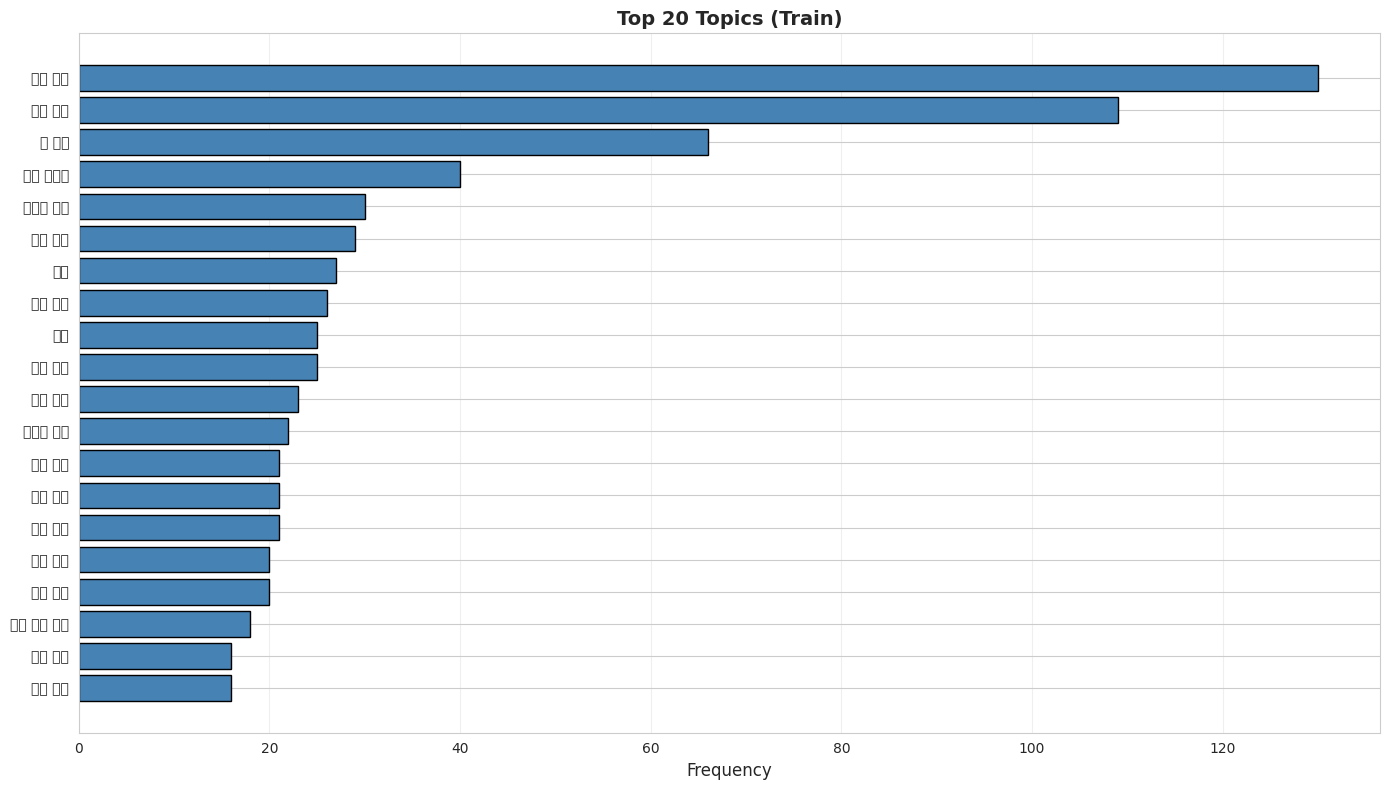


✅ 주제 분포 분석 완료


In [7]:
# 시각화: 상위 20개 주제
top_topics = topic_counts.head(20)

plt.figure(figsize=(14, 8))
plt.barh(range(len(top_topics)), top_topics.values[::-1], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_topics)), top_topics.index[::-1])
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 20 Topics (Train)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ 주제 분포 분석 완료")

## 5. 화자(Speaker) 분석


화자 수 분포 (Train):
num_speakers
2    12335
3      107
4       10
5        3
6        1
7        1
Name: count, dtype: int64


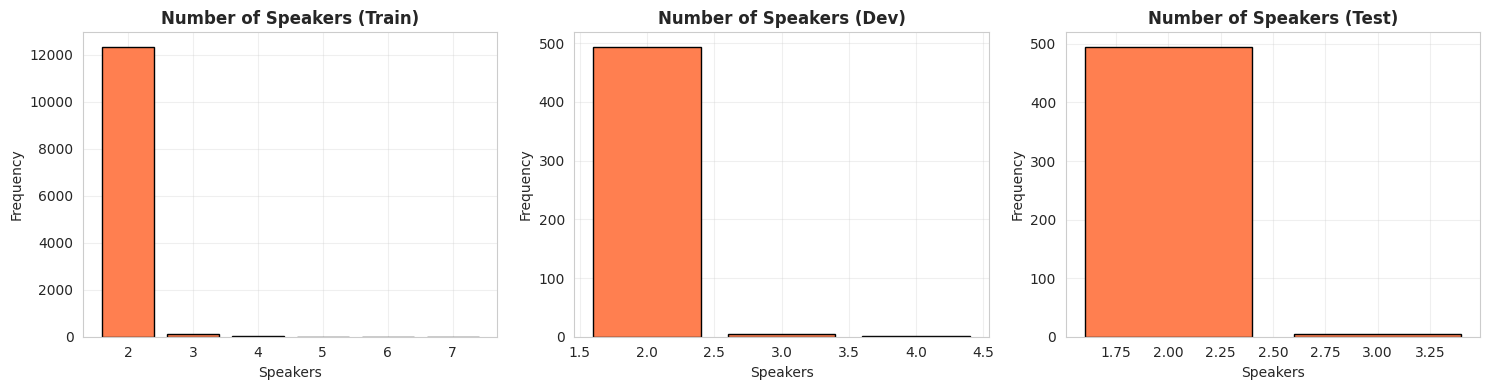


✅ 화자 분석 완료


In [8]:
# 화자 수 계산
def count_speakers(dialogue):
    """대화에서 고유 화자 수 계산"""
    # "#Person1#", "#Person2#" 패턴 찾기
    speakers = re.findall(r'#Person\d+#', dialogue)
    return len(set(speakers))

train_df['num_speakers'] = train_df['dialogue'].apply(count_speakers)
dev_df['num_speakers'] = dev_df['dialogue'].apply(count_speakers)
test_df['num_speakers'] = test_df['dialogue'].apply(count_speakers)

print("\n화자 수 분포 (Train):")
print(train_df['num_speakers'].value_counts().sort_index())

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df, name) in enumerate([(train_df, 'Train'), (dev_df, 'Dev'), (test_df, 'Test')]):
    speaker_counts = df['num_speakers'].value_counts().sort_index()
    axes[idx].bar(speaker_counts.index, speaker_counts.values, color='coral', edgecolor='black')
    axes[idx].set_title(f'Number of Speakers ({name})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Speakers')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 화자 분석 완료")

## 6. 발화(Utterance) 분석


발화 수 통계 (Train):
count    12457.000000
mean         9.484707
std          4.145838
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         59.000000
Name: num_utterances, dtype: float64


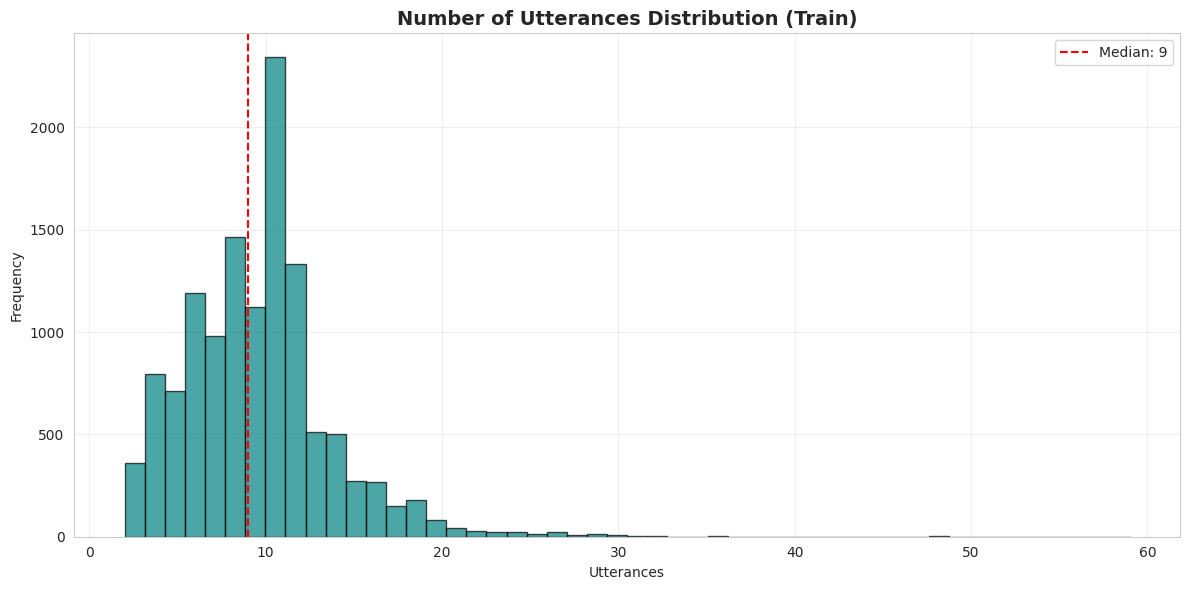


✅ 발화 분석 완료


In [9]:
# 발화 수 계산 (줄바꿈 기준)
def count_utterances(dialogue):
    """대화에서 발화 수 계산 (#Person 패턴 개수)"""
    return len(re.findall(r'#Person\d+#:', dialogue))

train_df['num_utterances'] = train_df['dialogue'].apply(count_utterances)
dev_df['num_utterances'] = dev_df['dialogue'].apply(count_utterances)
test_df['num_utterances'] = test_df['dialogue'].apply(count_utterances)

print("\n발화 수 통계 (Train):")
print(train_df['num_utterances'].describe())

# 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_df['num_utterances'], bins=50, alpha=0.7, color='teal', edgecolor='black')
plt.axvline(train_df['num_utterances'].median(), color='red', linestyle='--', 
            label=f'Median: {train_df["num_utterances"].median():.0f}')
plt.title('Number of Utterances Distribution (Train)', fontsize=14, fontweight='bold')
plt.xlabel('Utterances')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ 발화 분석 완료")

## 7. 토큰 길이 분석 (KoBART Tokenizer)

**목적**: KoBART 모델의 입력 제약 확인
- Encoder max length: 512 tokens
- Decoder max length: 100 tokens
- 초과 샘플 확인 및 truncation 영향 분석

In [10]:
# KoBART Tokenizer 로드
from transformers import AutoTokenizer

print("토큰라이저 로딩 중...")
tokenizer = AutoTokenizer.from_pretrained('digit82/kobart-summarization')
print(f"✅ Tokenizer 로드 완료 (Vocab size: {len(tokenizer):,})")

# 토큰 길이 계산 함수
def count_tokens(text, tokenizer):
    """텍스트를 토큰화하고 개수 반환"""
    return len(tokenizer.encode(text, add_special_tokens=True))

# Train 데이터 토큰화 (tqdm으로 진행상황 표시)
print("\n토큰화 진행 중...")
print("Train dialogue 토큰화...")
train_df['dialogue_tokens'] = train_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
print("Train summary 토큰화...")
train_df['summary_tokens'] = train_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("Dev dialogue 토큰화...")
dev_df['dialogue_tokens'] = dev_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))
print("Dev summary 토큰화...")
dev_df['summary_tokens'] = dev_df['summary'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("Test dialogue 토큰화...")
test_df['dialogue_tokens'] = test_df['dialogue'].progress_apply(lambda x: count_tokens(x, tokenizer))

print("\n✅ 토큰화 완료")

# 통계 출력
print("\n" + "="*80)
print("토큰 길이 통계 (Train)")
print("="*80)
print("\n[Dialogue Tokens]")
print(train_df['dialogue_tokens'].describe())
print("\n[Summary Tokens]")
print(train_df['summary_tokens'].describe())

# 512 토큰 초과 분석 (Encoder)
over_512 = train_df[train_df['dialogue_tokens'] > 512]
print(f"\n⚠️  Dialogue 512 토큰 초과: {len(over_512):,} samples ({len(over_512)/len(train_df)*100:.2f}%)")
print(f"   최대 토큰 수: {train_df['dialogue_tokens'].max():,} tokens")

# 100 토큰 초과 분석 (Decoder)
over_100 = train_df[train_df['summary_tokens'] > 100]
print(f"\n⚠️  Summary 100 토큰 초과: {len(over_100):,} samples ({len(over_100)/len(train_df)*100:.2f}%)")
print(f"   최대 토큰 수: {train_df['summary_tokens'].max():,} tokens")

# 문자 수 vs 토큰 수 비율
train_df['char_to_token_ratio'] = train_df['dialogue_len'] / train_df['dialogue_tokens']
print(f"\n평균 문자/토큰 비율: {train_df['char_to_token_ratio'].mean():.2f}")
print(f"(한국어 평균: 1 토큰 ≈ {train_df['char_to_token_ratio'].mean():.2f} 문자)")

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


토큰라이저 로딩 중...
✅ Tokenizer 로드 완료 (Vocab size: 30,000)

토큰화 진행 중...
Train dialogue 토큰화...


100%|██████████| 12457/12457 [00:02<00:00, 5200.14it/s]


Train summary 토큰화...


100%|██████████| 12457/12457 [00:00<00:00, 15499.36it/s]


Dev dialogue 토큰화...


100%|██████████| 499/499 [00:00<00:00, 5076.21it/s]


Dev summary 토큰화...


100%|██████████| 499/499 [00:00<00:00, 15410.24it/s]


Test dialogue 토큰화...


100%|██████████| 499/499 [00:00<00:00, 4902.62it/s]


✅ 토큰화 완료

토큰 길이 통계 (Train)

[Dialogue Tokens]
count    12457.000000
mean       199.561532
std         93.123736
min         42.000000
25%        141.000000
50%        183.000000
75%        245.000000
max       1079.000000
Name: dialogue_tokens, dtype: float64

[Summary Tokens]
count    12457.000000
mean        39.971984
std         15.149897
min          6.000000
25%         29.000000
50%         37.000000
75%         48.000000
max        161.000000
Name: summary_tokens, dtype: float64

⚠️  Dialogue 512 토큰 초과: 136 samples (1.09%)
   최대 토큰 수: 1,079 tokens

⚠️  Summary 100 토큰 초과: 48 samples (0.39%)
   최대 토큰 수: 161 tokens

평균 문자/토큰 비율: 2.03
(한국어 평균: 1 토큰 ≈ 2.03 문자)


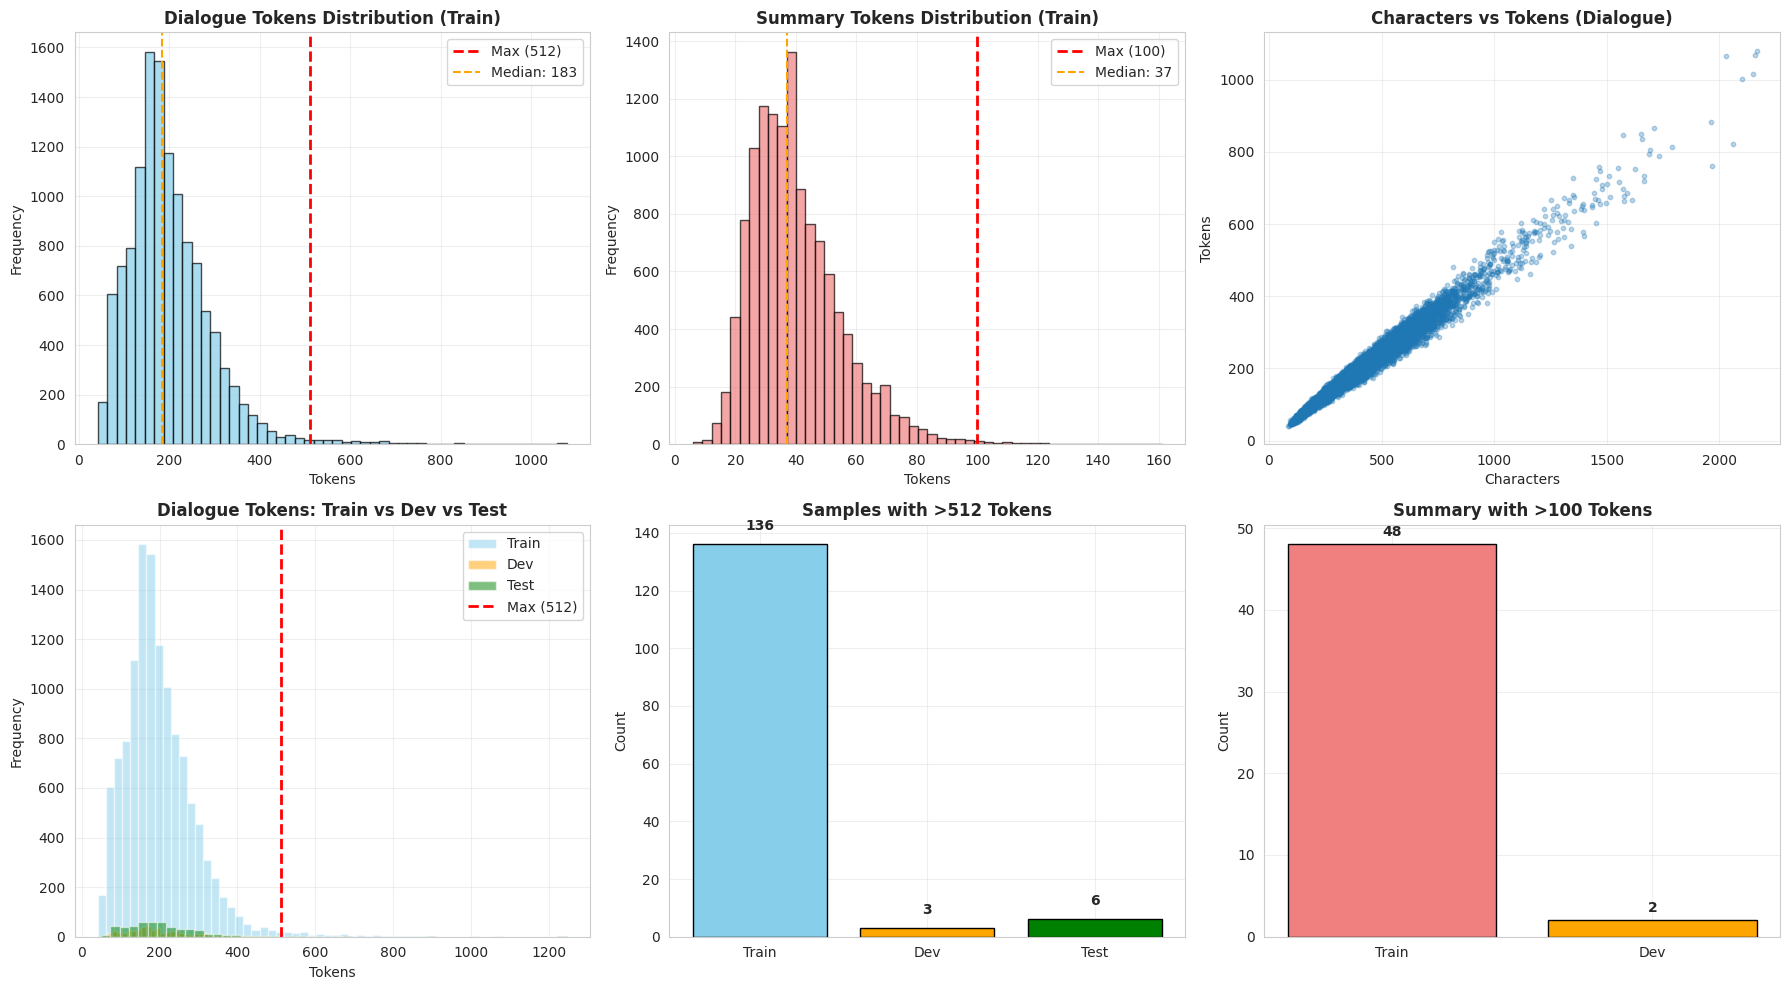


✅ 토큰 길이 분석 완료


In [11]:
# 시각화: 토큰 길이 분포
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Dialogue Tokens (Train)
axes[0, 0].hist(train_df['dialogue_tokens'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(512, color='red', linestyle='--', linewidth=2, label='Max (512)')
axes[0, 0].axvline(train_df['dialogue_tokens'].median(), color='orange', linestyle='--', label=f'Median: {train_df["dialogue_tokens"].median():.0f}')
axes[0, 0].set_title('Dialogue Tokens Distribution (Train)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Tokens')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Summary Tokens (Train)
axes[0, 1].hist(train_df['summary_tokens'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(100, color='red', linestyle='--', linewidth=2, label='Max (100)')
axes[0, 1].axvline(train_df['summary_tokens'].median(), color='orange', linestyle='--', label=f'Median: {train_df["summary_tokens"].median():.0f}')
axes[0, 1].set_title('Summary Tokens Distribution (Train)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tokens')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 문자 vs 토큰 비율
axes[0, 2].scatter(train_df['dialogue_len'], train_df['dialogue_tokens'], alpha=0.3, s=10)
axes[0, 2].set_title('Characters vs Tokens (Dialogue)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Characters')
axes[0, 2].set_ylabel('Tokens')
axes[0, 2].grid(alpha=0.3)

# Train vs Dev vs Test Dialogue Tokens
axes[1, 0].hist(train_df['dialogue_tokens'], bins=50, alpha=0.5, label='Train', color='skyblue')
axes[1, 0].hist(dev_df['dialogue_tokens'], bins=50, alpha=0.5, label='Dev', color='orange')
axes[1, 0].hist(test_df['dialogue_tokens'], bins=50, alpha=0.5, label='Test', color='green')
axes[1, 0].axvline(512, color='red', linestyle='--', linewidth=2, label='Max (512)')
axes[1, 0].set_title('Dialogue Tokens: Train vs Dev vs Test', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Tokens')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 512 초과 샘플 분석
truncation_analysis = pd.DataFrame({
    'Dataset': ['Train', 'Dev', 'Test'],
    'Over 512': [
        (train_df['dialogue_tokens'] > 512).sum(),
        (dev_df['dialogue_tokens'] > 512).sum(),
        (test_df['dialogue_tokens'] > 512).sum()
    ]
})
axes[1, 1].bar(truncation_analysis['Dataset'], truncation_analysis['Over 512'], color=['skyblue', 'orange', 'green'], edgecolor='black')
axes[1, 1].set_title('Samples with >512 Tokens', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(alpha=0.3)
for i, v in enumerate(truncation_analysis['Over 512']):
    axes[1, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 100 초과 샘플 분석 (Summary)
summary_over = pd.DataFrame({
    'Dataset': ['Train', 'Dev'],
    'Over 100': [
        (train_df['summary_tokens'] > 100).sum(),
        (dev_df['summary_tokens'] > 100).sum()
    ]
})
axes[1, 2].bar(summary_over['Dataset'], summary_over['Over 100'], color=['lightcoral', 'orange'], edgecolor='black')
axes[1, 2].set_title('Summary with >100 Tokens', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Count')
axes[1, 2].grid(alpha=0.3)
for i, v in enumerate(summary_over['Over 100']):
    axes[1, 2].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ 토큰 길이 분석 완료")

## 8. 특수 패턴 분석

**목적**: 시간, 금액, 전화번호 등 특수 패턴 빈도 분석
- Special Token 전략 수립에 활용
- 데이터 특성 파악

특수 패턴 분석 중...

[시간]
  총 출현 횟수: 8,764
  포함 샘플 수: 3,642 (29.24%)

[금액]
  총 출현 횟수: 1,664
  포함 샘플 수: 935 (7.51%)

[전화번호_마스킹]
  총 출현 횟수: 228
  포함 샘플 수: 151 (1.21%)

[주소_마스킹]
  총 출현 횟수: 89
  포함 샘플 수: 81 (0.65%)

[여권번호_마스킹]
  총 출현 횟수: 7
  포함 샘플 수: 5 (0.04%)

[숫자]
  총 출현 횟수: 133,405
  포함 샘플 수: 12,457 (100.00%)



/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/4011354875.py:61: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) Dej

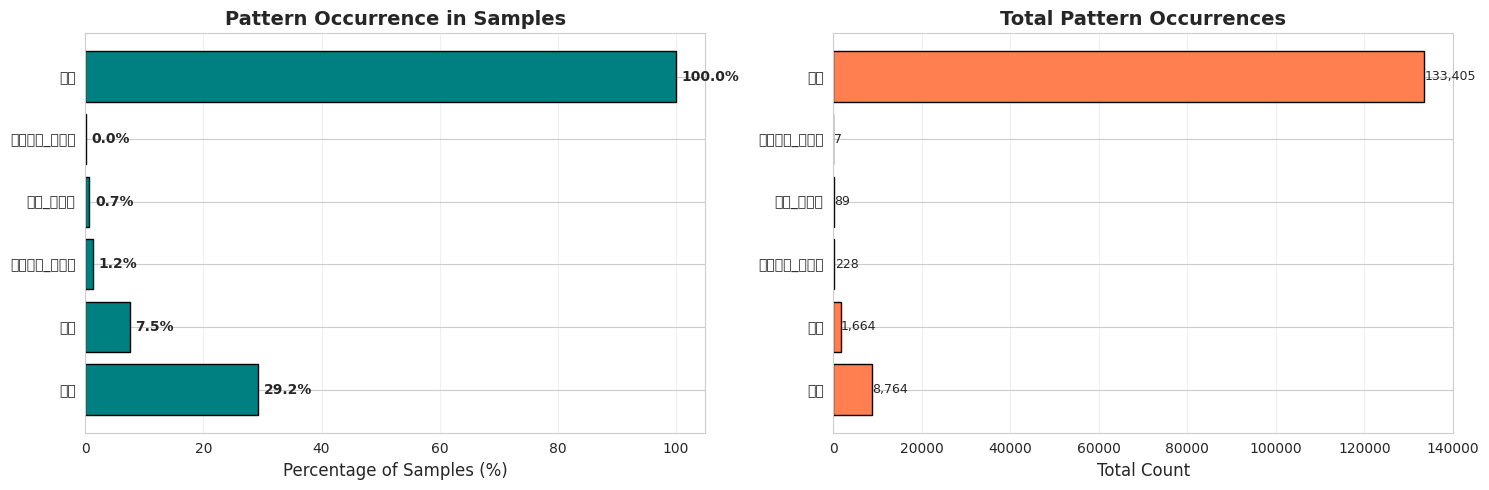


✅ 특수 패턴 분석 완료


In [12]:
# 특수 패턴 정규식 정의
import re

patterns = {
    '시간': r'\d+시|\d+분|\d+초|오전|오후|내일|어제|다음주|지난주|\d+월|\d+일|\d+년도|\d+개월',
    '금액': r'\d+원|\d+만원|\d+억|\$\d+|\d+달러|\d+,\d+원',
    '전화번호_마스킹': r'#PhoneNumber#',
    '주소_마스킹': r'#Address#',
    '여권번호_마스킹': r'#PassportNumber#',
    '숫자': r'\d+',
}

def count_patterns(text, pattern):
    """텍스트에서 패턴 개수 세기"""
    return len(re.findall(pattern, text))

# 각 패턴별 빈도 계산
print("특수 패턴 분석 중...\n")
pattern_results = {}

for pattern_name, pattern_regex in patterns.items():
    train_df[f'pattern_{pattern_name}'] = train_df['dialogue'].apply(lambda x: count_patterns(x, pattern_regex))
    
    total_count = train_df[f'pattern_{pattern_name}'].sum()
    samples_with_pattern = (train_df[f'pattern_{pattern_name}'] > 0).sum()
    
    pattern_results[pattern_name] = {
        'total_count': total_count,
        'samples_with_pattern': samples_with_pattern,
        'percentage': samples_with_pattern / len(train_df) * 100
    }
    
    print(f"[{pattern_name}]")
    print(f"  총 출현 횟수: {total_count:,}")
    print(f"  포함 샘플 수: {samples_with_pattern:,} ({samples_with_pattern/len(train_df)*100:.2f}%)")
    print()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 패턴별 출현 샘플 비율
pattern_names = list(pattern_results.keys())
percentages = [pattern_results[name]['percentage'] for name in pattern_names]

axes[0].barh(pattern_names, percentages, color='teal', edgecolor='black')
axes[0].set_xlabel('Percentage of Samples (%)', fontsize=12)
axes[0].set_title('Pattern Occurrence in Samples', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(percentages):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')

# 패턴별 총 출현 횟수
counts = [pattern_results[name]['total_count'] for name in pattern_names]
axes[1].barh(pattern_names, counts, color='coral', edgecolor='black')
axes[1].set_xlabel('Total Count', fontsize=12)
axes[1].set_title('Total Pattern Occurrences', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(counts):
    axes[1].text(v + 100, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ 특수 패턴 분석 완료")

## 9. PII 마스킹 패턴 분석

**목적**: 개인정보 마스킹 패턴 확인
- #Person1#, #Person2# 등 화자 마스킹
- #PhoneNumber#, #Address# 등 민감정보 마스킹

PII 마스킹 패턴 분석

[Person]
  Train: 12,457 samples (100.00%)
  Dev:   499 samples (100.00%)

[PhoneNumber]
  Train: 151 samples (1.21%)
  Dev:   5 samples (1.00%)

[Address]
  Train: 81 samples (0.65%)
  Dev:   2 samples (0.40%)

[PassportNumber]
  Train: 5 samples (0.04%)
  Dev:   0 samples (0.00%)

[CardNumber]
  Train: 12 samples (0.10%)
  Dev:   0 samples (0.00%)

[DateOfBirth]
  Train: 20 samples (0.16%)
  Dev:   2 samples (0.40%)



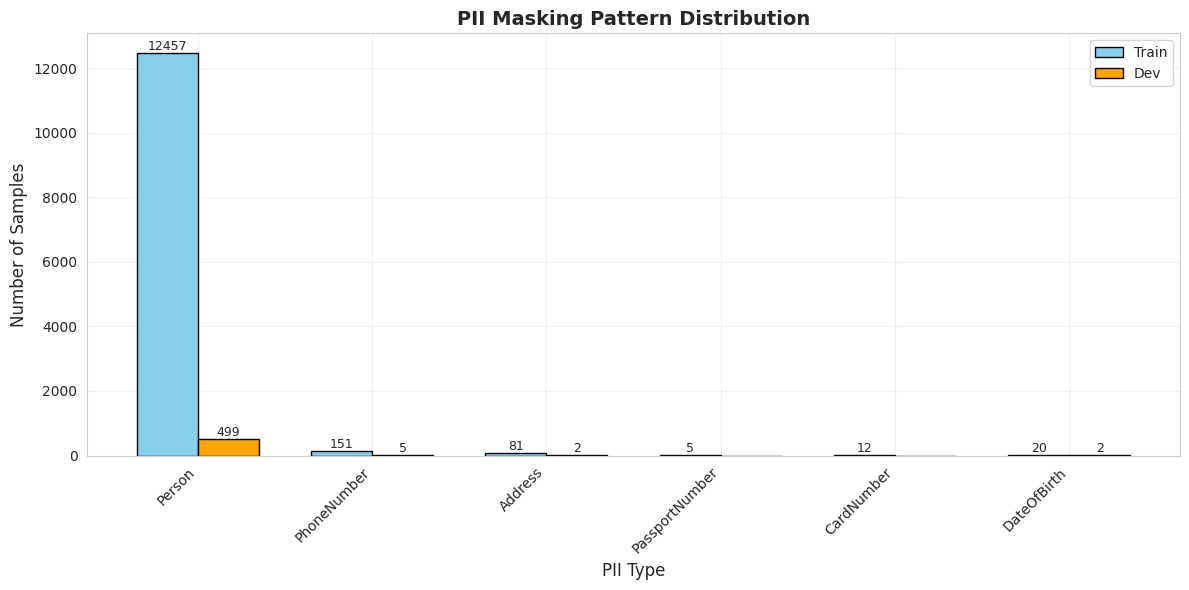

✅ PII 마스킹 패턴 분석 완료


In [13]:
# PII 패턴 정의
pii_patterns = {
    'Person': r'#Person\d+#',
    'PhoneNumber': r'#PhoneNumber#',
    'Address': r'#Address#',
    'PassportNumber': r'#PassportNumber#',
    'CardNumber': r'#CardNumber#',
    'DateOfBirth': r'#DateOfBirth#'
}

print("PII 마스킹 패턴 분석\n")
print("="*80)

pii_results = {}
for pii_name, pii_regex in pii_patterns.items():
    train_df[f'pii_{pii_name}'] = train_df['dialogue'].apply(lambda x: count_patterns(x, pii_regex))
    dev_df[f'pii_{pii_name}'] = dev_df['dialogue'].apply(lambda x: count_patterns(x, pii_regex))
    
    train_count = (train_df[f'pii_{pii_name}'] > 0).sum()
    dev_count = (dev_df[f'pii_{pii_name}'] > 0).sum()
    
    pii_results[pii_name] = {
        'train': train_count,
        'dev': dev_count
    }
    
    print(f"[{pii_name}]")
    print(f"  Train: {train_count:,} samples ({train_count/len(train_df)*100:.2f}%)")
    print(f"  Dev:   {dev_count:,} samples ({dev_count/len(dev_df)*100:.2f}%)")
    print()

# 시각화
pii_names = list(pii_results.keys())
train_counts = [pii_results[name]['train'] for name in pii_names]
dev_counts = [pii_results[name]['dev'] for name in pii_names]

x = np.arange(len(pii_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, dev_counts, width, label='Dev', color='orange', edgecolor='black')

ax.set_xlabel('PII Type', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('PII Masking Pattern Distribution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pii_names, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ PII 마스킹 패턴 분석 완료")

## 10. 문장 수 분석

**목적**: 대화와 요약의 문장 수 파악
- 문장 단위 압축 비율 계산
- 요약 스타일 파악

문장 수 계산 중...

문장 수 통계 (Train)

[Dialogue 문장 수]
count    12457.000000
mean        16.404672
std          8.133703
min          2.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         95.000000
Name: dialogue_sentences, dtype: float64

[Summary 문장 수]
count    12457.000000
mean         1.680822
std          0.820271
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          9.000000
Name: summary_sentences, dtype: float64

[문장 압축 비율 (dialogue/summary)]
count    12457.000000
mean        10.692895
std          5.043586
min          1.500000
25%          7.000000
50%         10.000000
75%         13.000000
max         63.000000
Name: sentence_compression_ratio, dtype: float64


/tmp/ipykernel_3489856/783857341.py:83: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/783857341.py:83: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/783857341.py:83: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/783857341.py:83: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/py

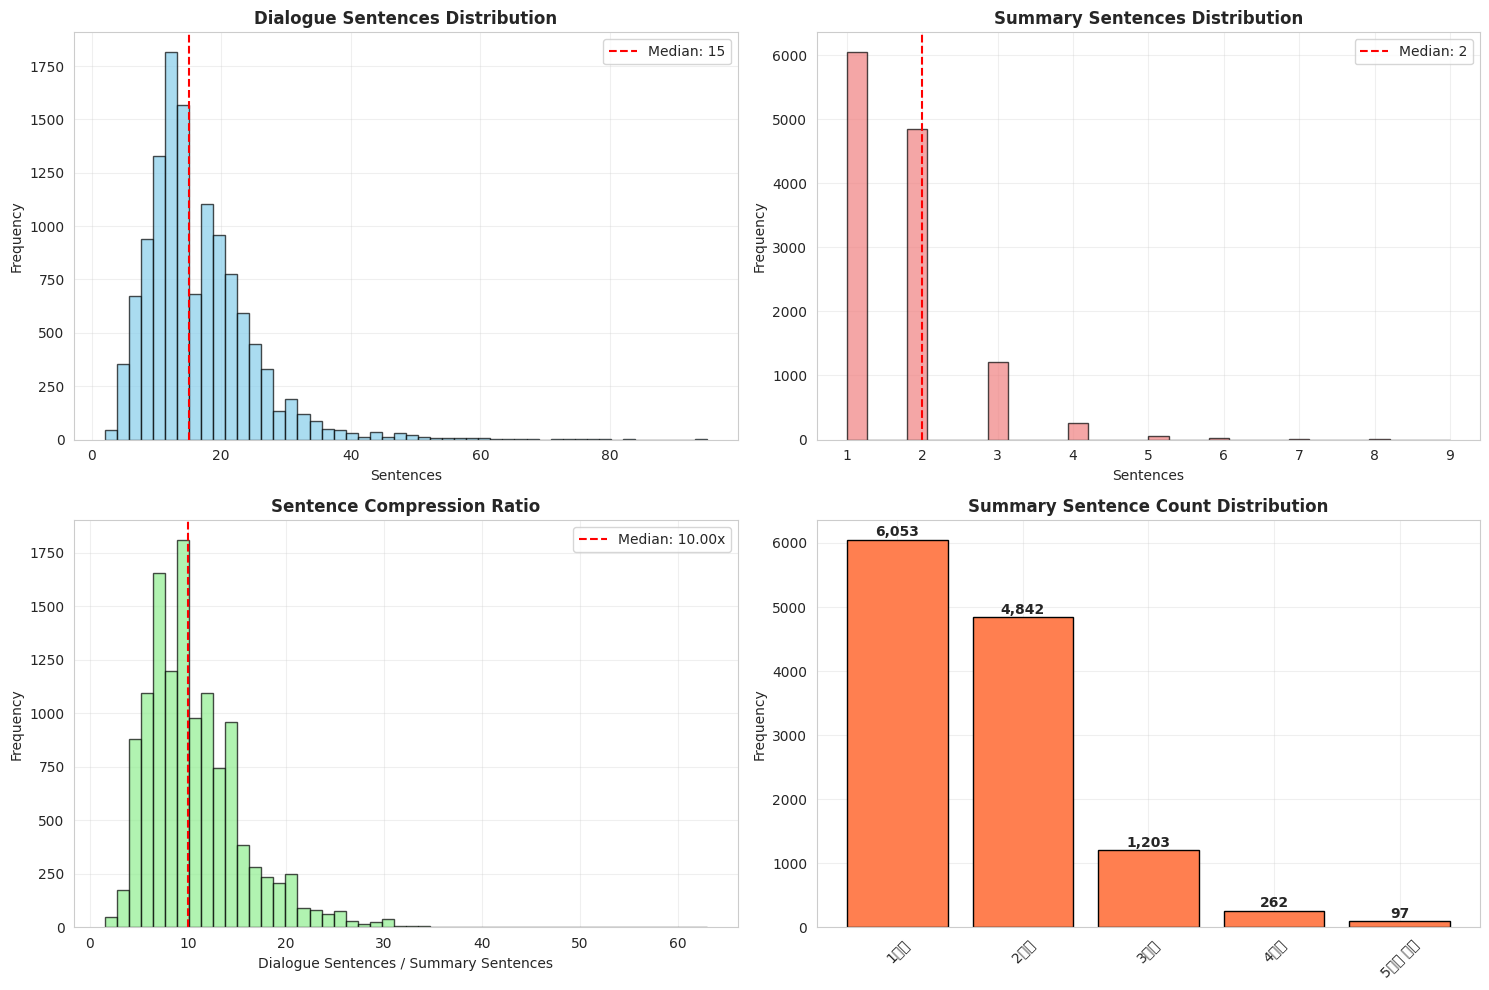


✅ 문장 수 분석 완료


In [14]:
# 문장 분리 함수 (한국어 기준)
def count_sentences(text):
    """한국어 문장 개수 세기 (. ! ? 기준)"""
    sentences = re.split(r'[.!?]\s+', text)
    # 빈 문자열 제거
    sentences = [s for s in sentences if s.strip()]
    return len(sentences)

print("문장 수 계산 중...\n")

# Train
train_df['dialogue_sentences'] = train_df['dialogue'].apply(count_sentences)
train_df['summary_sentences'] = train_df['summary'].apply(count_sentences)
train_df['sentence_compression_ratio'] = train_df['dialogue_sentences'] / train_df['summary_sentences']

# Dev
dev_df['dialogue_sentences'] = dev_df['dialogue'].apply(count_sentences)
dev_df['summary_sentences'] = dev_df['summary'].apply(count_sentences)
dev_df['sentence_compression_ratio'] = dev_df['dialogue_sentences'] / dev_df['summary_sentences']

# 통계
print("="*80)
print("문장 수 통계 (Train)")
print("="*80)
print("\n[Dialogue 문장 수]")
print(train_df['dialogue_sentences'].describe())
print("\n[Summary 문장 수]")
print(train_df['summary_sentences'].describe())
print("\n[문장 압축 비율 (dialogue/summary)]")
print(train_df['sentence_compression_ratio'].describe())

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dialogue 문장 수
axes[0, 0].hist(train_df['dialogue_sentences'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(train_df['dialogue_sentences'].median(), color='red', linestyle='--', 
                   label=f'Median: {train_df["dialogue_sentences"].median():.0f}')
axes[0, 0].set_title('Dialogue Sentences Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sentences')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Summary 문장 수
axes[0, 1].hist(train_df['summary_sentences'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(train_df['summary_sentences'].median(), color='red', linestyle='--', 
                   label=f'Median: {train_df["summary_sentences"].median():.0f}')
axes[0, 1].set_title('Summary Sentences Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentences')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 문장 압축 비율
axes[1, 0].hist(train_df['sentence_compression_ratio'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(train_df['sentence_compression_ratio'].median(), color='red', linestyle='--', 
                   label=f'Median: {train_df["sentence_compression_ratio"].median():.2f}x')
axes[1, 0].set_title('Sentence Compression Ratio', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Dialogue Sentences / Summary Sentences')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary 문장 수 분포 (1문장, 2문장, 3문장 이상)
sentence_dist = train_df['summary_sentences'].value_counts().sort_index()
categories = ['1문장', '2문장', '3문장', '4문장', '5문장 이상']
counts = [
    sentence_dist.get(1, 0),
    sentence_dist.get(2, 0),
    sentence_dist.get(3, 0),
    sentence_dist.get(4, 0),
    sentence_dist[sentence_dist.index >= 5].sum()
]
axes[1, 1].bar(categories, counts, color='coral', edgecolor='black')
axes[1, 1].set_title('Summary Sentence Count Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(counts):
    axes[1, 1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ 문장 수 분석 완료")

## 11. 어휘 다양성 분석 (Vocabulary Richness)

**목적**: 텍스트의 어휘 다양성 측정
- Type-Token Ratio (TTR): 고유 단어 수 / 전체 단어 수
- Dialogue vs Summary 비교

어휘 다양성 계산 중...

어휘 다양성 통계 (Train)

[Dialogue TTR]
count    12457.000000
mean         0.821670
std          0.062024
min          0.512500
25%          0.782051
50%          0.822785
75%          0.861538
max          1.000000
Name: dialogue_ttr, dtype: float64

[Summary TTR]
count    12457.000000
mean         0.973423
std          0.042065
min          0.705882
25%          0.947368
50%          1.000000
75%          1.000000
max          1.000000
Name: summary_ttr, dtype: float64

[Dialogue 평균 단어 수]
  고유: 68.6, 전체: 84.5
[Summary 평균 단어 수]
  고유: 15.9, 전체: 16.5


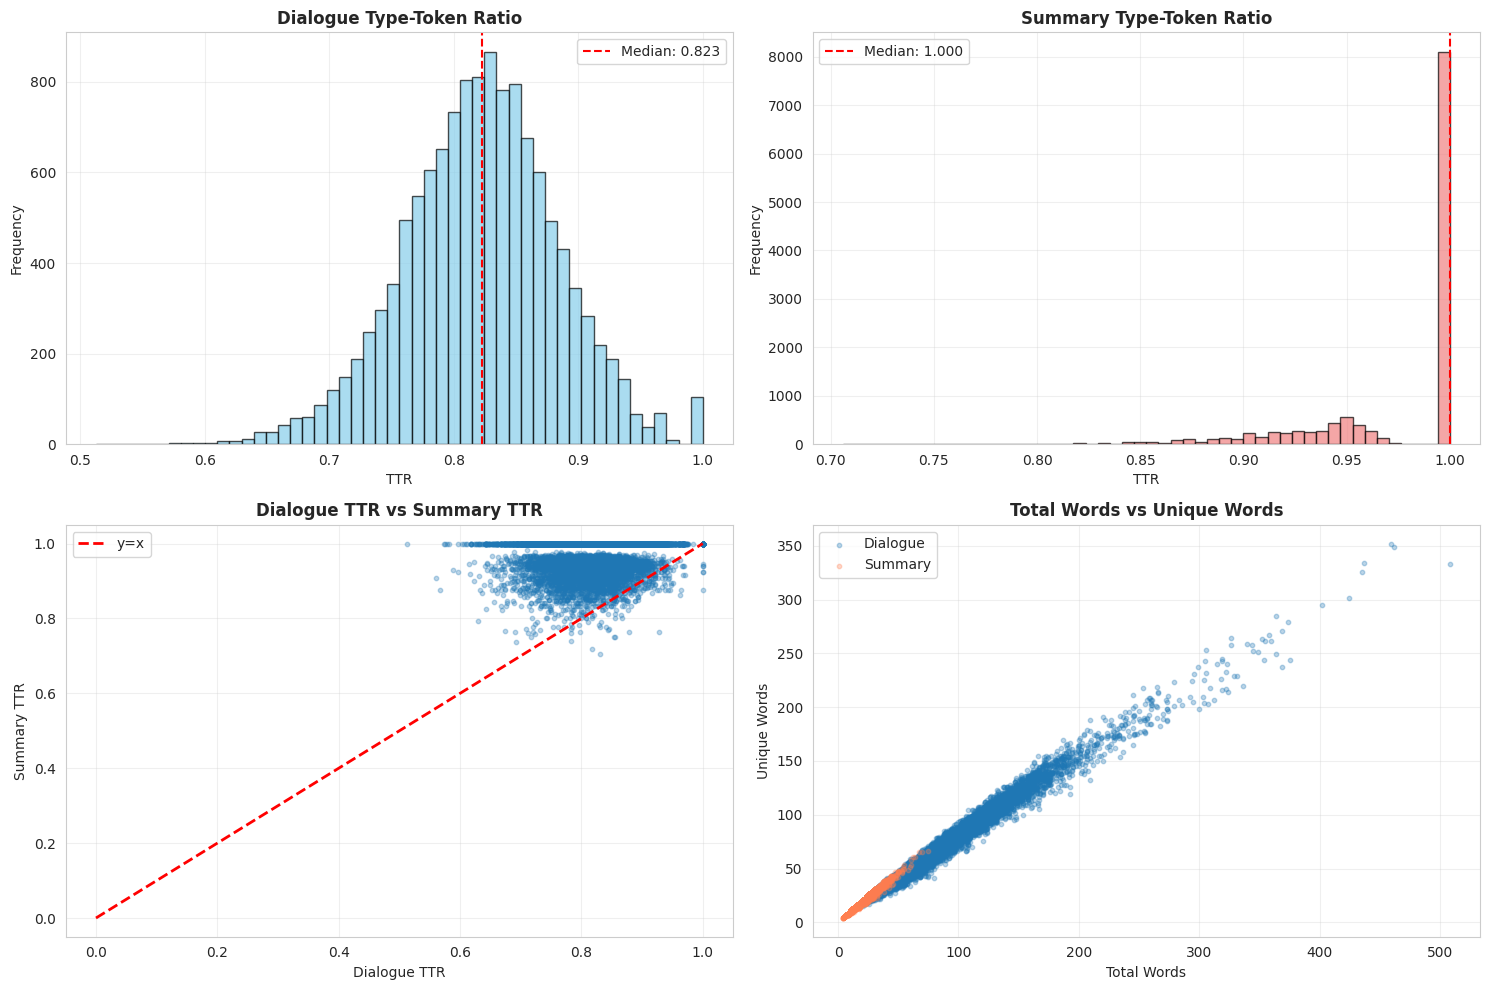


✅ 어휘 다양성 분석 완료


In [15]:
# 어휘 다양성 계산 함수
def calculate_ttr(text):
    """Type-Token Ratio 계산"""
    # 단어 분리 (공백 기준)
    words = text.split()
    if len(words) == 0:
        return 0
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words

def count_unique_words(text):
    """고유 단어 수"""
    words = text.split()
    return len(set(words))

def count_total_words(text):
    """전체 단어 수"""
    return len(text.split())

print("어휘 다양성 계산 중...\n")

# Train
train_df['dialogue_ttr'] = train_df['dialogue'].apply(calculate_ttr)
train_df['summary_ttr'] = train_df['summary'].apply(calculate_ttr)
train_df['dialogue_unique_words'] = train_df['dialogue'].apply(count_unique_words)
train_df['dialogue_total_words'] = train_df['dialogue'].apply(count_total_words)
train_df['summary_unique_words'] = train_df['summary'].apply(count_unique_words)
train_df['summary_total_words'] = train_df['summary'].apply(count_total_words)

# 통계
print("="*80)
print("어휘 다양성 통계 (Train)")
print("="*80)
print("\n[Dialogue TTR]")
print(train_df['dialogue_ttr'].describe())
print("\n[Summary TTR]")
print(train_df['summary_ttr'].describe())
print("\n[Dialogue 평균 단어 수]")
print(f"  고유: {train_df['dialogue_unique_words'].mean():.1f}, 전체: {train_df['dialogue_total_words'].mean():.1f}")
print("[Summary 평균 단어 수]")
print(f"  고유: {train_df['summary_unique_words'].mean():.1f}, 전체: {train_df['summary_total_words'].mean():.1f}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dialogue TTR 분포
axes[0, 0].hist(train_df['dialogue_ttr'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(train_df['dialogue_ttr'].median(), color='red', linestyle='--', 
                   label=f'Median: {train_df["dialogue_ttr"].median():.3f}')
axes[0, 0].set_title('Dialogue Type-Token Ratio', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('TTR')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Summary TTR 분포
axes[0, 1].hist(train_df['summary_ttr'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(train_df['summary_ttr'].median(), color='red', linestyle='--', 
                   label=f'Median: {train_df["summary_ttr"].median():.3f}')
axes[0, 1].set_title('Summary Type-Token Ratio', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('TTR')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Dialogue vs Summary TTR 비교
axes[1, 0].scatter(train_df['dialogue_ttr'], train_df['summary_ttr'], alpha=0.3, s=10)
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
axes[1, 0].set_title('Dialogue TTR vs Summary TTR', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Dialogue TTR')
axes[1, 0].set_ylabel('Summary TTR')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 고유 단어 수 vs 전체 단어 수
axes[1, 1].scatter(train_df['dialogue_total_words'], train_df['dialogue_unique_words'], alpha=0.3, s=10, label='Dialogue')
axes[1, 1].scatter(train_df['summary_total_words'], train_df['summary_unique_words'], alpha=0.3, s=10, label='Summary', color='coral')
axes[1, 1].set_title('Total Words vs Unique Words', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total Words')
axes[1, 1].set_ylabel('Unique Words')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ 어휘 다양성 분석 완료")

## 12. N-gram 분석

**목적**: 자주 등장하는 표현 패턴 파악
- Bi-gram (2-gram)
- Tri-gram (3-gram)
- Summary에서 자주 사용되는 표현

n-gram 추출 중...

[Bi-gram Top 30] (Summary)
#Person2#는 #Person1#에게                  : 1127
#Person1#은 #Person2#에게                  : 1086
#Person1#과 #Person2#는                   :  970
#Person1#이 #Person2#에게                  :  319
#Person1#은 #Person2#의                   :  311
수 있다고                                   :  288
대해 이야기합니다.                              :  264
#Person2#가 #Person1#에게                  :  234
#Person1#은 #Person2#가                   :  227
#Person2#는 #Person1#의                   :  216
대해 설명합니다.                               :  178
대해 이야기한다.                               :  161
#Person2#는 #Person1#이                   :  152
수 있는                                    :  124
수 있도록                                   :  118
것에 대해                                   :  116
있습니다. #Person1#은                        :  112
두 사람은                                   :  108
합니다. #Person1#은                         :  104
#Person2#는 그                            :  103
싶어 합니다.          

/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/2611393886.py:61: UserWarning: Glyph 46160 (\N{HANGUL SYLLABLE DU}) missing from font(s) DejaVu 

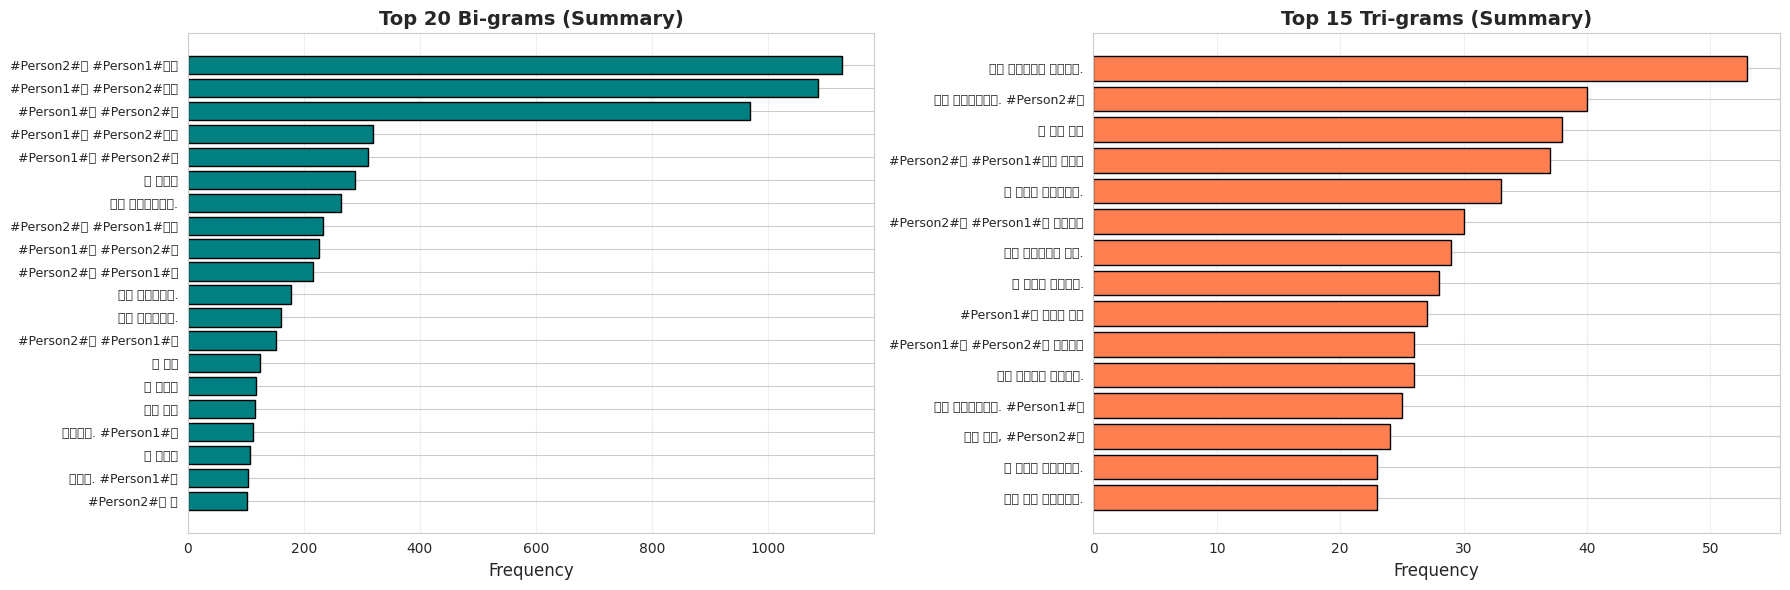


✅ n-gram 분석 완료


In [16]:
from collections import Counter
import itertools

def extract_ngrams(text, n=2):
    """n-gram 추출"""
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

print("n-gram 추출 중...\n")

# Summary에서 Bi-gram 추출
all_bigrams = []
for summary in train_df['summary']:
    all_bigrams.extend(extract_ngrams(summary, n=2))

bigram_counts = Counter(all_bigrams)
print("[Bi-gram Top 30] (Summary)")
print("="*80)
for bigram, count in bigram_counts.most_common(30):
    print(f"{bigram:40s}: {count:4d}")

# Summary에서 Tri-gram 추출
all_trigrams = []
for summary in train_df['summary']:
    all_trigrams.extend(extract_ngrams(summary, n=3))

trigram_counts = Counter(all_trigrams)
print("\n[Tri-gram Top 20] (Summary)")
print("="*80)
for trigram, count in trigram_counts.most_common(20):
    print(f"{trigram:50s}: {count:4d}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20 Bi-grams
top_bigrams = bigram_counts.most_common(20)
bigrams = [b for b, c in top_bigrams]
counts_bi = [c for b, c in top_bigrams]

axes[0].barh(range(len(bigrams)), counts_bi[::-1], color='teal', edgecolor='black')
axes[0].set_yticks(range(len(bigrams)))
axes[0].set_yticklabels(bigrams[::-1], fontsize=9)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 20 Bi-grams (Summary)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Top 15 Tri-grams
top_trigrams = trigram_counts.most_common(15)
trigrams = [t for t, c in top_trigrams]
counts_tri = [c for t, c in top_trigrams]

axes[1].barh(range(len(trigrams)), counts_tri[::-1], color='coral', edgecolor='black')
axes[1].set_yticks(range(len(trigrams)))
axes[1].set_yticklabels(trigrams[::-1], fontsize=9)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Tri-grams (Summary)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ n-gram 분석 완료")

## 13. 성능 문제 샘플 분석

**목적**: 모델이 어려워할 수 있는 샘플 특성 파악
- 긴 대화 (상위 10%)
- 복잡한 대화 (화자 3명 이상)
- 512 토큰 초과
- 낮은 압축 비율 (정보 밀도 높음)

성능 문제 샘플 분석

[긴 대화] (상위 10%)
  기준: 642 문자 이상
  샘플 수: 1,233
  평균 길이: 823 문자
  최대 길이: 2165 문자

[복잡한 대화] (화자 3명 이상)
  샘플 수: 122 (0.98%)
  평균 화자 수: 3.2
  최대 화자 수: 7

[512 토큰 초과] (Truncation 발생)
  샘플 수: 136 (1.09%)
  평균 토큰 수: 638
  최대 토큰 수: 1079

[낮은 압축 비율] (하위 10%, 정보 밀도 높음)
  기준: 2.98x 미만
  샘플 수: 1,246
  평균 압축 비율: 2.47x

[복합 문제 샘플] (2개 이상 조건 만족)
  샘플 수: 157 (1.26%)



/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 44596 (\N{HANGUL SYLLABLE GIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 51105 (\N{HANGUL SYLLABLE JAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489856/607035634.py:103: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu

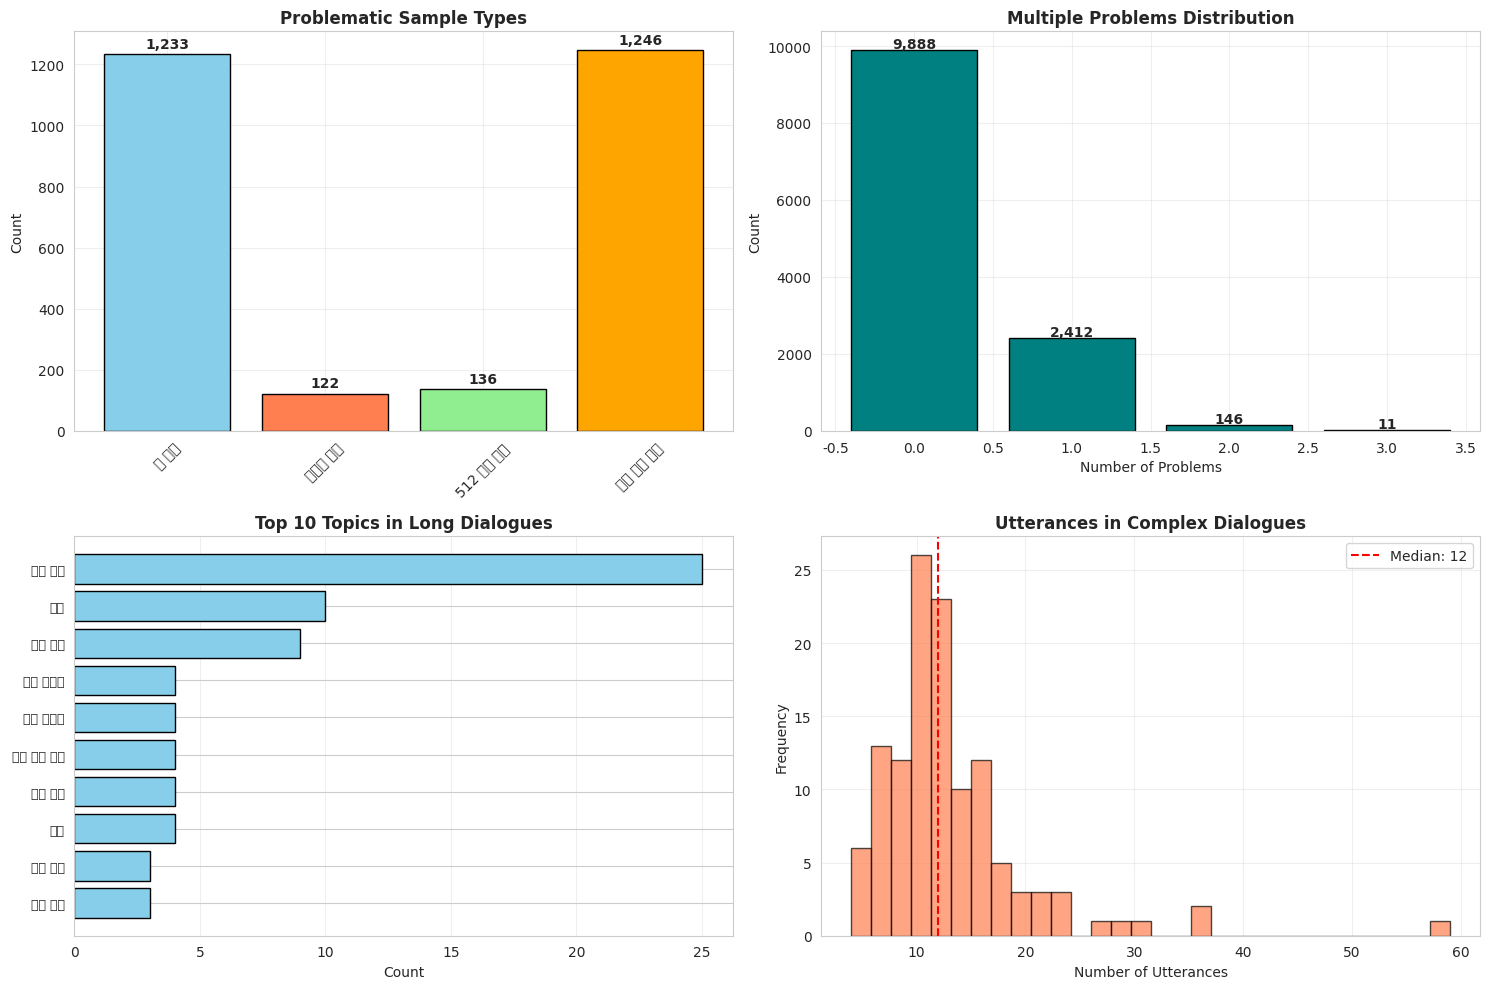

✅ 성능 문제 샘플 분석 완료


In [17]:
print("성능 문제 샘플 분석\n")
print("="*80)

# 1. 긴 대화 (상위 10%)
dialogue_len_90 = train_df['dialogue_len'].quantile(0.9)
long_dialogues = train_df[train_df['dialogue_len'] > dialogue_len_90]
print(f"[긴 대화] (상위 10%)")
print(f"  기준: {dialogue_len_90:.0f} 문자 이상")
print(f"  샘플 수: {len(long_dialogues):,}")
print(f"  평균 길이: {long_dialogues['dialogue_len'].mean():.0f} 문자")
print(f"  최대 길이: {long_dialogues['dialogue_len'].max():.0f} 문자")
print()

# 2. 복잡한 대화 (화자 3명 이상)
complex_dialogues = train_df[train_df['num_speakers'] >= 3]
print(f"[복잡한 대화] (화자 3명 이상)")
print(f"  샘플 수: {len(complex_dialogues):,} ({len(complex_dialogues)/len(train_df)*100:.2f}%)")
print(f"  평균 화자 수: {complex_dialogues['num_speakers'].mean():.1f}")
print(f"  최대 화자 수: {complex_dialogues['num_speakers'].max()}")
print()

# 3. 512 토큰 초과
over_512_samples = train_df[train_df['dialogue_tokens'] > 512]
print(f"[512 토큰 초과] (Truncation 발생)")
print(f"  샘플 수: {len(over_512_samples):,} ({len(over_512_samples)/len(train_df)*100:.2f}%)")
print(f"  평균 토큰 수: {over_512_samples['dialogue_tokens'].mean():.0f}")
print(f"  최대 토큰 수: {over_512_samples['dialogue_tokens'].max()}")
print()

# 4. 낮은 압축 비율 (하위 10%)
compression_10 = train_df['compression_ratio'].quantile(0.1)
low_compression = train_df[train_df['compression_ratio'] < compression_10]
print(f"[낮은 압축 비율] (하위 10%, 정보 밀도 높음)")
print(f"  기준: {compression_10:.2f}x 미만")
print(f"  샘플 수: {len(low_compression):,}")
print(f"  평균 압축 비율: {low_compression['compression_ratio'].mean():.2f}x")
print()

# 5. 복합 문제 샘플 (위 조건 중 2개 이상 만족)
train_df['is_long'] = train_df['dialogue_len'] > dialogue_len_90
train_df['is_complex'] = train_df['num_speakers'] >= 3
train_df['is_over_512'] = train_df['dialogue_tokens'] > 512
train_df['is_low_compression'] = train_df['compression_ratio'] < compression_10

train_df['problem_count'] = (train_df['is_long'].astype(int) + 
                              train_df['is_complex'].astype(int) + 
                              train_df['is_over_512'].astype(int) + 
                              train_df['is_low_compression'].astype(int))

multiple_problems = train_df[train_df['problem_count'] >= 2]
print(f"[복합 문제 샘플] (2개 이상 조건 만족)")
print(f"  샘플 수: {len(multiple_problems):,} ({len(multiple_problems)/len(train_df)*100:.2f}%)")
print()

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 문제 유형별 샘플 수
problem_types = ['긴 대화', '복잡한 대화', '512 토큰 초과', '낮은 압축 비율']
problem_counts = [
    len(long_dialogues),
    len(complex_dialogues),
    len(over_512_samples),
    len(low_compression)
]
axes[0, 0].bar(problem_types, problem_counts, color=['skyblue', 'coral', 'lightgreen', 'orange'], edgecolor='black')
axes[0, 0].set_title('Problematic Sample Types', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3)
for i, v in enumerate(problem_counts):
    axes[0, 0].text(i, v + 20, f'{v:,}', ha='center', fontweight='bold')

# 복합 문제 분포
problem_dist = train_df['problem_count'].value_counts().sort_index()
axes[0, 1].bar(problem_dist.index, problem_dist.values, color='teal', edgecolor='black')
axes[0, 1].set_title('Multiple Problems Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Problems')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(alpha=0.3)
for i, v in enumerate(problem_dist.values):
    axes[0, 1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# 긴 대화의 주제 분포 (상위 10개)
long_topics = long_dialogues['topic'].value_counts().head(10)
axes[1, 0].barh(range(len(long_topics)), long_topics.values[::-1], color='skyblue', edgecolor='black')
axes[1, 0].set_yticks(range(len(long_topics)))
axes[1, 0].set_yticklabels(long_topics.index[::-1], fontsize=9)
axes[1, 0].set_title('Top 10 Topics in Long Dialogues', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Count')
axes[1, 0].grid(axis='x', alpha=0.3)

# 복잡한 대화의 발화 수 분포
axes[1, 1].hist(complex_dialogues['num_utterances'], bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1, 1].axvline(complex_dialogues['num_utterances'].median(), color='red', linestyle='--', 
                   label=f'Median: {complex_dialogues["num_utterances"].median():.0f}')
axes[1, 1].set_title('Utterances in Complex Dialogues', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Utterances')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 성능 문제 샘플 분석 완료")

## 14. Baseline 예측 vs 정답 비교 (선택적)

**목적**: Baseline 모델의 예측 결과 분석
- 저성능 샘플 특성 파악
- 개선 포인트 발견

**요구사항**: `prediction/output.csv` 파일 필요 (Dev set 예측)

Baseline 예측 파일 발견! 분석 시작...

ROUGE 점수 분포 (Dev set)

ROUGE-1 F1: 0.0069 (±0.0223)
ROUGE-2 F1: 0.0002 (±0.0033)
ROUGE-L F1: 0.0069 (±0.0223)
평균:        0.0047 (±0.0153)

[저성능 샘플] (하위 10%)
  ROUGE 평균 < 0.0000
  샘플 수: 0
  평균 대화 길이: nan 문자
  평균 토큰 수: nan tokens
  512 토큰 초과: 0 samples


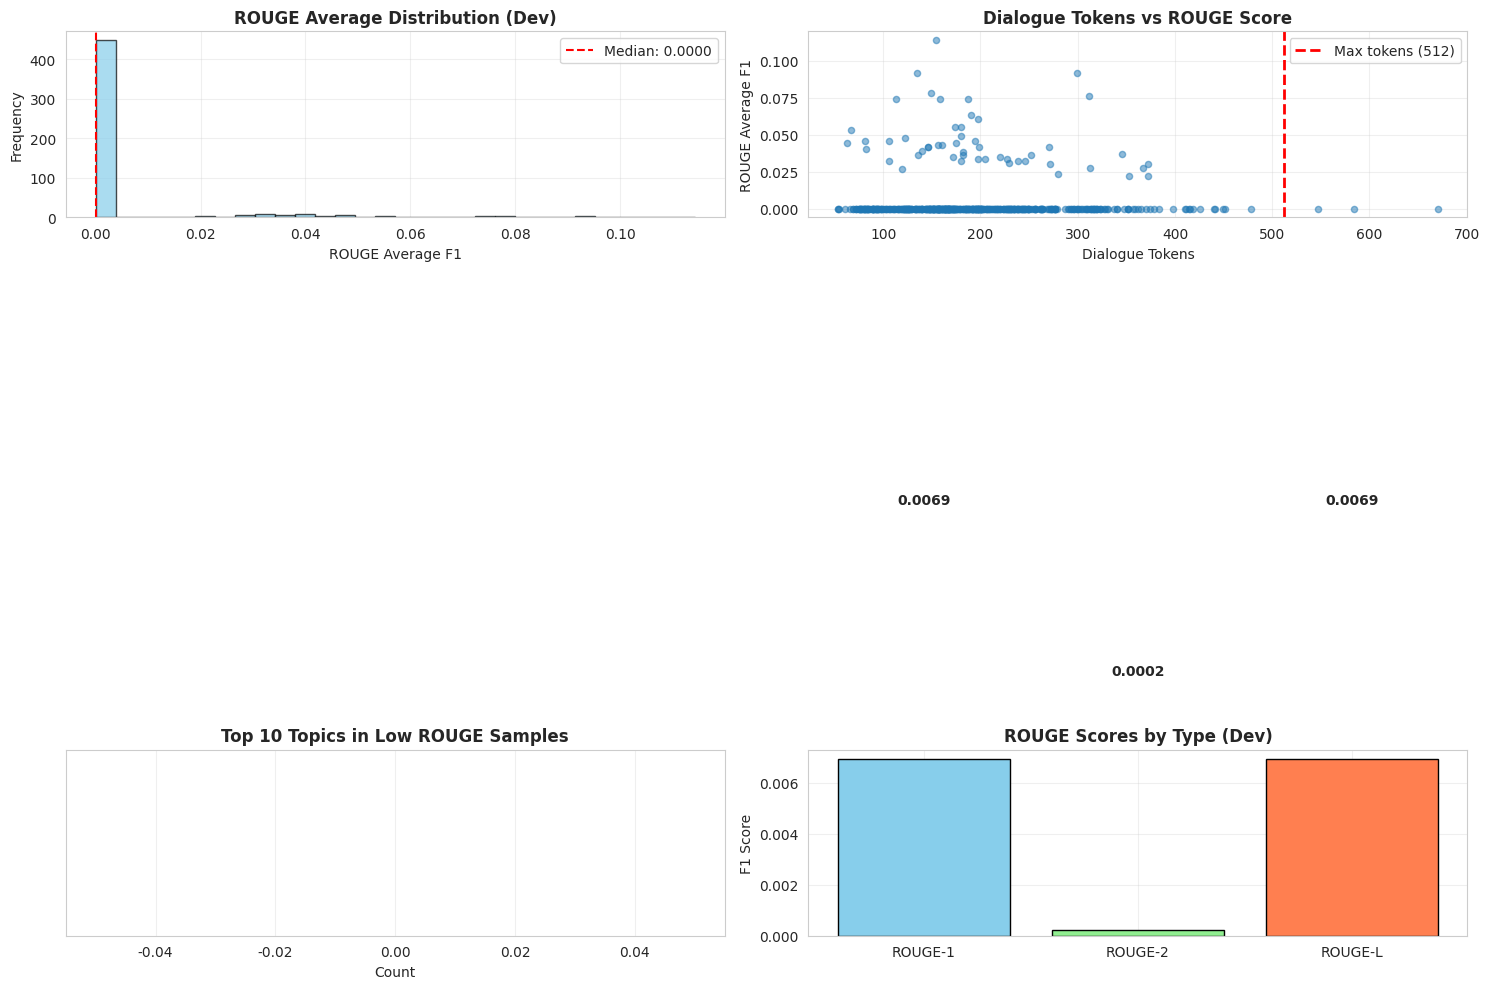


✅ Baseline 예측 분석 완료


In [22]:
import os
from rouge import Rouge

# Baseline 예측 파일 확인
prediction_path = './prediction/output_modular_v2.csv'

if os.path.exists(prediction_path):
    print("Baseline 예측 파일 발견! 분석 시작...\n")
    
    # 예측 파일 로드
    pred_df = pd.read_csv(prediction_path)
    
    # Dev set과 매칭 (fname 기준)
    # pred_df의 fname이 test_0, test_1 형식이면 dev_0, dev_1로 변환 필요
    # 또는 순서대로 매칭
    
    if len(pred_df) == len(dev_df):
        dev_df['predicted_summary'] = pred_df['summary'].values
        
        # ROUGE 점수 계산
        rouge = Rouge()
        scores = []
        
        for i, row in dev_df.iterrows():
            try:
                score = rouge.get_scores(row['predicted_summary'], row['summary'])[0]
                scores.append({
                    'rouge-1-f': score['rouge-1']['f'],
                    'rouge-2-f': score['rouge-2']['f'],
                    'rouge-l-f': score['rouge-l']['f']
                })
            except:
                scores.append({'rouge-1-f': 0, 'rouge-2-f': 0, 'rouge-l-f': 0})
        
        score_df = pd.DataFrame(scores)
        dev_df['rouge_1_f'] = score_df['rouge-1-f']
        dev_df['rouge_2_f'] = score_df['rouge-2-f']
        dev_df['rouge_l_f'] = score_df['rouge-l-f']
        dev_df['rouge_avg'] = (dev_df['rouge_1_f'] + dev_df['rouge_2_f'] + dev_df['rouge_l_f']) / 3
        
        # 통계
        print("="*80)
        print("ROUGE 점수 분포 (Dev set)")
        print("="*80)
        print(f"\nROUGE-1 F1: {dev_df['rouge_1_f'].mean():.4f} (±{dev_df['rouge_1_f'].std():.4f})")
        print(f"ROUGE-2 F1: {dev_df['rouge_2_f'].mean():.4f} (±{dev_df['rouge_2_f'].std():.4f})")
        print(f"ROUGE-L F1: {dev_df['rouge_l_f'].mean():.4f} (±{dev_df['rouge_l_f'].std():.4f})")
        print(f"평균:        {dev_df['rouge_avg'].mean():.4f} (±{dev_df['rouge_avg'].std():.4f})")
        
        # 저성능 샘플 (하위 10%)
        low_rouge_threshold = dev_df['rouge_avg'].quantile(0.1)
        low_rouge_samples = dev_df[dev_df['rouge_avg'] < low_rouge_threshold]
        
        print(f"\n[저성능 샘플] (하위 10%)")
        print(f"  ROUGE 평균 < {low_rouge_threshold:.4f}")
        print(f"  샘플 수: {len(low_rouge_samples)}")
        print(f"  평균 대화 길이: {low_rouge_samples['dialogue_len'].mean():.0f} 문자")
        print(f"  평균 토큰 수: {low_rouge_samples['dialogue_tokens'].mean():.0f} tokens")
        print(f"  512 토큰 초과: {(low_rouge_samples['dialogue_tokens'] > 512).sum()} samples")
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # ROUGE 점수 분포
        axes[0, 0].hist(dev_df['rouge_avg'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(dev_df['rouge_avg'].median(), color='red', linestyle='--', 
                           label=f'Median: {dev_df["rouge_avg"].median():.4f}')
        axes[0, 0].set_title('ROUGE Average Distribution (Dev)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('ROUGE Average F1')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # 대화 길이 vs ROUGE 점수
        axes[0, 1].scatter(dev_df['dialogue_tokens'], dev_df['rouge_avg'], alpha=0.5, s=20)
        axes[0, 1].axvline(512, color='red', linestyle='--', linewidth=2, label='Max tokens (512)')
        axes[0, 1].set_title('Dialogue Tokens vs ROUGE Score', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Dialogue Tokens')
        axes[0, 1].set_ylabel('ROUGE Average F1')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # 저성능 샘플의 주제 분포
        low_topics = low_rouge_samples['topic'].value_counts().head(10)
        axes[1, 0].barh(range(len(low_topics)), low_topics.values[::-1], color='coral', edgecolor='black')
        axes[1, 0].set_yticks(range(len(low_topics)))
        axes[1, 0].set_yticklabels(low_topics.index[::-1], fontsize=9)
        axes[1, 0].set_title('Top 10 Topics in Low ROUGE Samples', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Count')
        axes[1, 0].grid(axis='x', alpha=0.3)
        
        # ROUGE-1, ROUGE-2, ROUGE-L 비교
        rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
        rouge_means = [
            dev_df['rouge_1_f'].mean(),
            dev_df['rouge_2_f'].mean(),
            dev_df['rouge_l_f'].mean()
        ]
        axes[1, 1].bar(rouge_types, rouge_means, color=['skyblue', 'lightgreen', 'coral'], edgecolor='black')
        axes[1, 1].set_title('ROUGE Scores by Type (Dev)', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].grid(alpha=0.3)
        for i, v in enumerate(rouge_means):
            axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Baseline 예측 분석 완료")
    else:
        print(f"⚠️  예측 파일 크기 불일치: {len(pred_df)} vs {len(dev_df)}")
else:
    print("⚠️  Baseline 예측 파일이 없습니다.")
    print(f"   경로: {prediction_path}")
    print("   Baseline 모델을 먼저 실행해서 Dev set 예측을 생성하세요.")
    print("\n   이 분석을 건너뛰고 계속 진행합니다.")

## 15. EDA 완료 요약

### ✅ 완료된 분석:

1. **데이터 구조 확인** - 컬럼, 타입, 결측치
2. **텍스트 길이 분석** - 문자 단위, 압축 비율
3. **주제 분포** - 9,235개 고유 주제
4. **화자 분석** - 대부분 2명 대화
5. **발화 분석** - 대화 턴 수
6. **토큰 길이 분석** - KoBART tokenizer 기준
7. **특수 패턴 분석** - 시간, 금액, 전화번호 등
8. **PII 마스킹 분석** - 개인정보 마스킹 패턴
9. **문장 수 분석** - 문장 단위 압축 비율
10. **어휘 다양성 분석** - Type-Token Ratio
11. **N-gram 분석** - 자주 사용되는 표현
12. **성능 문제 샘플** - 긴 대화, 복잡한 구조
13. **Baseline 예측 비교** - ROUGE 점수 분석 (조건부)

### 💡 다음 단계:

**분석 결과 기반 개선 전략**:
1. 512 토큰 초과 샘플 처리 방안
2. Special Token 추가 (시간, 금액 등 고빈도 패턴)
3. 긴 대화/복잡한 구조 샘플 강화 학습
4. 저성능 주제 집중 학습

In [19]:
# 전체 EDA 완료
print("\n" + "="*80)
print("전체 EDA 완료")
print("="*80)
print("\n📊 분석 항목 (13개):")
print("  ✅ 1. 데이터 구조 확인")
print("  ✅ 2. 텍스트 길이 분석")
print("  ✅ 3. 주제 분포")
print("  ✅ 4. 화자 분석")
print("  ✅ 5. 발화 분석")
print("  ✅ 6. 토큰 길이 분석 (KoBART)")
print("  ✅ 7. 특수 패턴 분석")
print("  ✅ 8. PII 마스킹 분석")
print("  ✅ 9. 문장 수 분석")
print("  ✅ 10. 어휘 다양성 분석")
print("  ✅ 11. N-gram 분석")
print("  ✅ 12. 성능 문제 샘플 분석")
print("  ✅ 13. Baseline 예측 비교 (조건부)")
print("\n💡 이제 분석 결과를 바탕으로 모델 개선을 진행하세요!")
print("\n📁 데이터프레임 변수:")
print("  - train_df: 전체 Train 데이터 + 분석 결과")
print("  - dev_df: 전체 Dev 데이터 + 분석 결과")
print("  - test_df: 전체 Test 데이터 + 분석 결과")


전체 EDA 완료

📊 분석 항목 (13개):
  ✅ 1. 데이터 구조 확인
  ✅ 2. 텍스트 길이 분석
  ✅ 3. 주제 분포
  ✅ 4. 화자 분석
  ✅ 5. 발화 분석
  ✅ 6. 토큰 길이 분석 (KoBART)
  ✅ 7. 특수 패턴 분석
  ✅ 8. PII 마스킹 분석
  ✅ 9. 문장 수 분석
  ✅ 10. 어휘 다양성 분석
  ✅ 11. N-gram 분석
  ✅ 12. 성능 문제 샘플 분석
  ✅ 13. Baseline 예측 비교 (조건부)

💡 이제 분석 결과를 바탕으로 모델 개선을 진행하세요!

📁 데이터프레임 변수:
  - train_df: 전체 Train 데이터 + 분석 결과
  - dev_df: 전체 Dev 데이터 + 분석 결과
  - test_df: 전체 Test 데이터 + 분석 결과
